Integrantes  
Bryann Alfaro  
Raul Jimenez  
Donaldo Garcia

In [1]:
pip install scapy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Parte 1 - Analisis de paquetes

 Analisis estadistico

In [2]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

REFERENCIA: JUPYTER BRINDADO EN CLASE

Capture 10 paquetes con la herramienta scapy, imprima el tipo de datos, la longitud y el
contenido del pcap

In [3]:
pcap = sniff(count=10) #captura de 10 paquetes

In [4]:
#Impresion de tipo de dato, longitud y contenido
print(type(pcap))
print(len(pcap))
for i in range(len(pcap)):
  print(pcap[i])
pcap[0]

<class 'scapy.plist.PacketList'>
10
Ether / IP / UDP / NBNSHeader / NBNSQueryRequest who has '\\4'
Ether / IP / UDP / DNS Ans "b'iPhone de Jairon._rdlink._tcp.local.'" 
Ether / IP / UDP 10.100.7.34:netbios_dgm > 10.100.31.255:netbios_dgm / NBTDatagram / Raw
Ether / IP / UDP / DNS Ans "fe80::1090:8242:2e4d:f487" 
Ether / IP / UDP / NBNSHeader / NBNSQueryRequest who has '\\WPAD'
Ether / IP / UDP / DNS Qry "b'wpad.local.'" 
Ether / IP / UDP 10.100.2.235:49195 > 239.255.255.250:ws_discovery / Raw
Ether / IP / UDP 10.100.9.237:62917 > 239.255.255.250:ssdp / Raw
Ether / IP / UDP / DNS Qry "b'_companion-link._tcp.local.'" 
Ether / IP / UDP 10.100.2.2:2008 > 10.100.31.255:2008 / Raw


<Ether  dst=ff:ff:ff:ff:ff:ff src=ac:2b:6e:93:2f:d8 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=78 id=6015 flags= frag=0 ttl=128 proto=udp chksum=0x1379 src=192.168.70.87 dst=192.168.71.255 |<UDP  sport=netbios_ns dport=netbios_ns len=58 chksum=0xd036 |<NBNSHeader  NAME_TRN_ID=58660 RESPONSE=0 OPCODE=0 NM_FLAGS=B+RD RCODE=0 QDCOUNT=1 ANCOUNT=0 NSCOUNT=0 ARCOUNT=0 |<NBNSQueryRequest  QUESTION_NAME='4              ' SUFFIX=workstation NULL=0 QUESTION_TYPE=NB QUESTION_CLASS=INTERNET |>>>>>

Para conocer un poco mas se puede hacer la exploracion

In [5]:
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload #recupera la informacion de la capa 4

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / IP / UDP / NBNSHeader / NBNSQueryRequest who has '\\4'
Informacion del paquete:
IP / UDP / NBNSHeader / NBNSQueryRequest who has '\\4'
Informacion del segmento:
UDP / NBNSHeader / NBNSQueryRequest who has '\\4'
Data:
NBNSHeader / NBNSQueryRequest who has '\\4'
###[ Ethernet ]### 
  dst       = ff:ff:ff:ff:ff:ff
  src       = ac:2b:6e:93:2f:d8
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 78
     id        = 6015
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = udp
     chksum    = 0x1379
     src       = 192.168.70.87
     dst       = 192.168.71.255
     \options   \
###[ UDP ]### 
        sport     = netbios_ns
        dport     = netbios_ns
        len       = 58
        chksum    = 0xd036
###[ NBNS Header ]### 
           NAME_TRN_ID= 58660
           RESPONSE  = 0
           OPCODE    = 0
           NM_FLAGS  = B+RD
           RCODE     = 0
           QDCOUNT   = 

In [6]:
pcap2 = rdpcap('analisis_paquetes.pcap')

In [7]:
print(len(pcap2))

62


In [8]:
print(len(pcap))

10


Convierta el pcap a un DataFrame  
Se saca el DF de ambos pcap y luego se unen 

In [9]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos  len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   78   6015          0  128    17   4985  ...    None   
1       4   5   0  358  56218          0  255    17  61531  ...    None   
2       4   5   0  247  54096          0  128    17  10941  ...    None   
3       4   5   0  148  11426          0  255    17  40733  ...    None   
4       4   5   0   78  46142          0  128    17  20739  ...    None   

  reserved flags  window chksum urgptr options payload  \
0     None  None    None  53302   None    None      50   
1     None  None    None  35949   None    None     330   
2     None  None    None  46217   None    None     219   
3     None  None    None   9258   None    None     120   
4     None  None    None  47839   None    None      50   

                                         payload_raw  \
0  b'\xe5$\x01\x10\x00\x01\x00\x00\x00\x00\x00\x0...   
1  b'\x00\x00\x84\x00\x00\x00\x00\x02\x00\x00\x00...   
2  b'\x11\x02\x81\x8b\nd\x07"\x0

In [10]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df2 = pd.DataFrame(columns=dataframe_fields)
for packet in pcap2[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df2 = pd.concat([df2, df_append], axis=0)

# Reset Index
df2 = df2.reset_index()
# Drop old index column
df2 = df2.drop(columns="index")

print(df2.head(5))

  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   961      1          0   64    17  21222  ...    None   
1       4   5  32    84  58919          0  122    17  13836  ...    None   
2       4   5   0   975      1          0   64    17  21208  ...    None   
3       4   5  32    84  59493          0  122    17  13262  ...    None   
4       4   5   0  1012      1          0   64    17  21171  ...    None   

  reserved flags window chksum urgptr options payload  \
0     None  None   None  62990   None    None     933   
1     None  None   None  65061   None    None      56   
2     None  None   None  36378   None    None     947   
3     None  None   None  65063   None    None      56   
4     None  None   None  63846   None    None     984   

                                         payload_raw  \
0  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
1  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...   
2  b'\x00\x0c\x01\x00\x00\x01\x0

Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port

In [11]:
df_new = pd.concat([df,df2])

In [12]:
df_new.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

In [13]:
df_new.shape

(72, 28)

In [14]:
df_new['src']

0     192.168.70.87
1       10.100.3.49
2       10.100.7.34
3       10.100.4.58
4      10.100.0.151
          ...      
57      84.54.22.33
58       10.1.10.53
59      84.54.22.33
60       10.1.10.53
61      84.54.22.33
Name: src, Length: 72, dtype: object

In [15]:
df_new['src'].value_counts()

10.1.10.53       31
84.54.22.33      29
75.75.75.75       2
192.168.70.87     1
10.100.3.49       1
10.100.7.34       1
10.100.4.58       1
10.100.0.151      1
10.100.9.143      1
10.100.2.235      1
10.100.9.237      1
10.100.1.200      1
10.100.2.2        1
Name: src, dtype: int64

In [16]:
df_new['dst']

0     192.168.71.255
1        224.0.0.251
2      10.100.31.255
3        224.0.0.251
4      10.100.31.255
           ...      
57        10.1.10.53
58       84.54.22.33
59        10.1.10.53
60       84.54.22.33
61        10.1.10.53
Name: dst, Length: 72, dtype: object

In [17]:
df_new['dst'].value_counts()

10.1.10.53         31
84.54.22.33        29
224.0.0.251         4
10.100.31.255       3
239.255.255.250     2
75.75.75.75         2
192.168.71.255      1
Name: dst, dtype: int64

In [18]:
df_new['sport']

0      137
1     5353
2      138
3     5353
4      137
      ... 
57      53
58      53
59      53
60      53
61      53
Name: sport, Length: 72, dtype: object

In [19]:
df_new['sport'].value_counts()

53       60
5353      4
137       2
138       1
49195     1
62917     1
2008      1
15812     1
23903     1
Name: sport, dtype: int64

In [20]:
df_new['dport']

0      137
1     5353
2      138
3     5353
4      137
      ... 
57      53
58      53
59      53
60      53
61      53
Name: dport, Length: 72, dtype: object

In [21]:
df_new['dport'].value_counts()

53       60
5353      4
137       2
138       1
3702      1
1900      1
2008      1
15812     1
23903     1
Name: dport, dtype: int64

# Estadísticas

In [22]:
#Muestre cual es la IP origen más frecuente
source_ip = df_new['src'].value_counts(ascending=False).index[0]
source_ip

'10.1.10.53'

In [23]:
#Muestre cual es la IP destino más frecuente
dest_ip = df_new['dst'].value_counts(ascending=False).index[0]
dest_ip

'10.1.10.53'

In [24]:
#¿A qué IPs se comunica la IP del inciso a?
df_new[df_new['src']==source_ip][['src','dst']]

,src,dst
0,10.1.10.53,84.54.22.33
2,10.1.10.53,84.54.22.33
4,10.1.10.53,84.54.22.33
6,10.1.10.53,84.54.22.33
8,10.1.10.53,84.54.22.33
10,10.1.10.53,84.54.22.33
12,10.1.10.53,84.54.22.33
14,10.1.10.53,84.54.22.33
16,10.1.10.53,84.54.22.33
18,10.1.10.53,84.54.22.33


In [25]:
#¿A qué puertos destino se comunica la IP del inciso a?
df_new[df_new['src']==source_ip][['src','dport']]

,src,dport
0,10.1.10.53,53
2,10.1.10.53,53
4,10.1.10.53,53
6,10.1.10.53,53
8,10.1.10.53,53
10,10.1.10.53,53
12,10.1.10.53,53
14,10.1.10.53,53
16,10.1.10.53,53
18,10.1.10.53,53


In [26]:
#¿A qué puertos origen se comunica la IP del inciso b?
df_new[df_new['dst']==dest_ip][['dst','sport']]

,dst,sport
1,10.1.10.53,53
3,10.1.10.53,53
5,10.1.10.53,53
7,10.1.10.53,53
9,10.1.10.53,53
11,10.1.10.53,53
13,10.1.10.53,53
15,10.1.10.53,53
17,10.1.10.53,53
19,10.1.10.53,53


#### Indique el propósito de los puertos que más aparece en los incisos d y e:

**En este caso el puerto que mas aparece es el puerto 53 el cual es utilizado por servicios DNS y permite usar tanto TCP como UDP para comunicarse con servidores DNS.** 

# Graficas

<AxesSubplot: ylabel='src'>

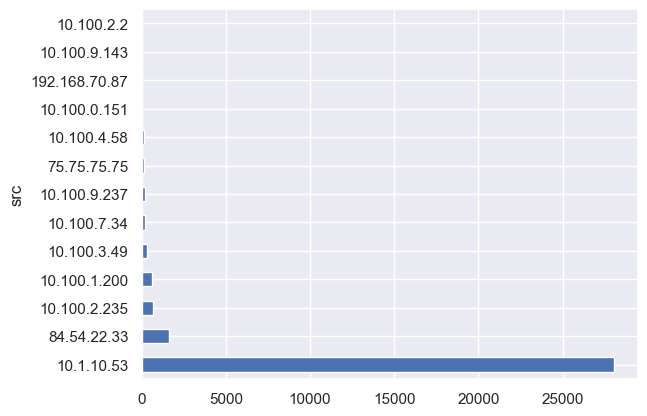

In [27]:
#Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads
#enviados de dichas direcciones.

df_new.groupby('src')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<AxesSubplot: ylabel='dst'>

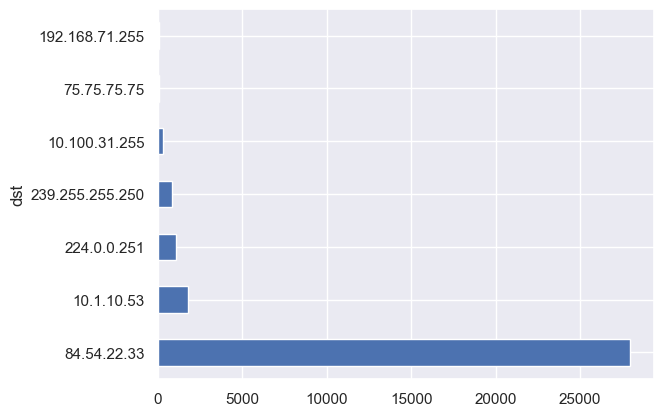

In [28]:
# Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

df_new.groupby('dst')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<AxesSubplot: ylabel='sport'>

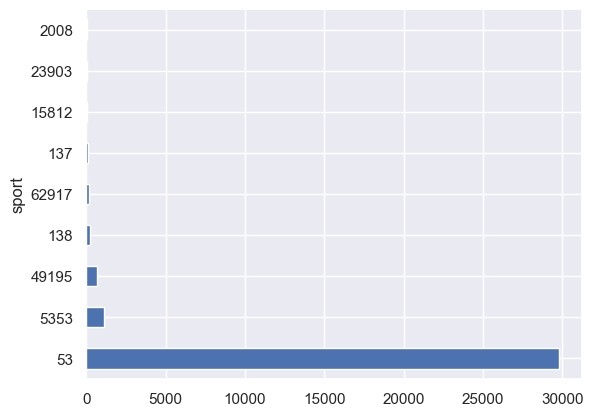

In [29]:
# Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los
# payloads enviados de dichos puertos.

df_new.groupby('sport')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<AxesSubplot: ylabel='dport'>

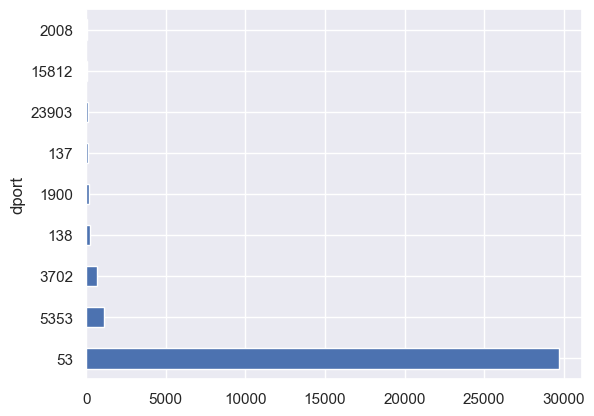

In [30]:
# Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los
# payloads recibidos en dichos puertos.

df_new.groupby('dport')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

# Investigación del payload

In [31]:
# Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen
# más frecuente

df_frecuent_ip = df_new[df_new['src']==source_ip]
df_frecuent_ip.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [32]:
# Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por
# payload

# df_frecuent_ip_new = df_frecuent_ip.groupby(['src','dst'])['payload'].sum().sort_values(ascending=False)
# df_frecuent_ip_new = df.groupby(by=["payload"])[['src', 'dst', 'payload']]
# df_frecuent_ip_new

df_frecuent_ip_new = df.groupby(by=["payload"])
df_frecuent_ip_new = df[['src', 'dst', 'payload']]
df_frecuent_ip_new

,src,dst,payload
0,192.168.70.87,192.168.71.255,50
1,10.100.3.49,224.0.0.251,330
2,10.100.7.34,10.100.31.255,219
3,10.100.4.58,224.0.0.251,120
4,10.100.0.151,10.100.31.255,50
5,10.100.9.143,224.0.0.251,28
6,10.100.2.235,239.255.255.250,656
7,10.100.9.237,239.255.255.250,175
8,10.100.1.200,224.0.0.251,614
9,10.100.2.2,10.100.31.255,20


In [33]:
# Obtenga la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es
# sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

# suspicious_ip = df_frecuent_ip_new.index[0][1]
max_payload = df_frecuent_ip['payload'].max()
max_payload

1023

In [34]:
df_suspicious_comunication = df_new[(df_new['payload'] == max_payload) & (df_new['src']==source_ip) ]
suspicious_ip = df_suspicious_comunication['dst'].values[0]
suspicious_ip

'84.54.22.33'

In [49]:
# Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.
df_comunication = df_new[(df_new['src']==source_ip) & (df_new['dst']==suspicious_ip)]
df_comunication[['src','dst','payload']]

,src,dst,payload
0,10.1.10.53,84.54.22.33,933
2,10.1.10.53,84.54.22.33,947
4,10.1.10.53,84.54.22.33,984
6,10.1.10.53,84.54.22.33,970
8,10.1.10.53,84.54.22.33,975
10,10.1.10.53,84.54.22.33,1017
12,10.1.10.53,84.54.22.33,980
14,10.1.10.53,84.54.22.33,951
16,10.1.10.53,84.54.22.33,931
18,10.1.10.53,84.54.22.33,964


In [36]:
# Obtenga los payloads del DF del inciso 6, y añada cada uno en un array

payloads_array = df_comunication['payload_raw'].to_numpy()

In [37]:
# Muestre el contenido del array.
payloads_array

array([b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\

#### Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envié a través del puerto explicado en el inciso f?

**Analizando los datos del dataframe se puede ver que estos solo se comunican a travez del puerto 53 y que estos payloads son mayormente unicos.**

In [50]:
test_port = df_comunication.groupby(by=["dport"])
test_port = df_comunication[['src', 'dst', 'payload', 'payload_raw', 'dport']]
test_port.shape

(29, 5)

In [54]:
test_port['payload'].value_counts()

978     3
976     2
1009    2
933     1
941     1
999     1
989     1
977     1
991     1
985     1
982     1
1007    1
1011    1
958     1
947     1
1023    1
964     1
931     1
951     1
980     1
1017    1
975     1
970     1
984     1
560     1
Name: payload, dtype: int64

In [51]:
test_port

,src,dst,payload,payload_raw,dport
0,10.1.10.53,84.54.22.33,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
2,10.1.10.53,84.54.22.33,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
4,10.1.10.53,84.54.22.33,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
6,10.1.10.53,84.54.22.33,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
8,10.1.10.53,84.54.22.33,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
10,10.1.10.53,84.54.22.33,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
12,10.1.10.53,84.54.22.33,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
14,10.1.10.53,84.54.22.33,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
16,10.1.10.53,84.54.22.33,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
18,10.1.10.53,84.54.22.33,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
